In [11]:
import os
import numpy as np
import tensorflow as tf

def get_files( file_dir ):
    aluminum = []
    label = []
    for i in range( 12 ):
        for file in os.listdir( file_dir + '/' + str( i ) ):
            if not file.endswith('.jpg') or file.startswith('.'):
                continue  # Skip!
            aluminum.append( file_dir + '/' + str( i ) + '/' + file )
            label.append( i )
    temp = np.array([ aluminum, label ])
    temp = temp.transpose()
    np.random.shuffle( temp )

    aluminum_list = list( temp[:, 0] )
    label_list = list( temp[:, 1] )
    label_list_temp = [int(i) for i in label_list]
    label_list = np.zeros( [len( label_list_temp ), 12] )
    for i in range( len(label_list_temp ) ):
        label_list[i][label_list_temp[i]] = 1
    
    return aluminum_list, label_list

In [12]:
def get_batch( image, label, image_width, image_height, batch_size, capacity):
    image = tf.cast( image, tf.string )
    label = tf.cast( label, tf.float32 )
    
    input_queue = tf.train.slice_input_producer( [image, label] )
    
    label = input_queue[1]
    image_contents = tf.read_file( input_queue[0] )
    image = tf.image.decode_jpeg(image_contents, channels=3) 
    image = tf.image.resize_image_with_crop_or_pad(image, image_width
                                                   , image_height)
    image = tf.image.per_image_standardization(image)
    
    image_batch, label_batch = tf.train.batch( [image, label],
                                                                 batch_size = batch_size,
                                                                  num_threads = 1, 
                                                                 capacity = capacity )
    label_batch = tf.reshape(  label_batch, [batch_size, 12] )
    #label_batch = tf.zeros( [batch_size, 12], dtype = tf.float32 )
    #for i in range( batch_size ):
    #    label_batch[label_batch_temp[i]] = tf.Variable(1)
    #image_batch = tf.cast( image_batch, tf.float32 )
    #image_batch = tf.subtract( image_batch, 128 )
    #image_batch = tf.div( image_batch, 128 )
    
    return image_batch, label_batch

In [13]:
BATCH_SIZE = 8
CAPACITY = 100
IMG_W = 512
IMG_H = 256

train_dir = '/Users/alala/codes/python/contest/guangdong_round1_train2_20180916'
image_list, label_list = get_files( train_dir )
image_batch, label_batch = get_batch( image_list, label_list, IMG_W, IMG_H, BATCH_SIZE, CAPACITY )

In [14]:
def weight_variable( shape ):
    initial = tf.truncated_normal( shape, stddev = 0.1 )
    return tf.Variable( initial )

def bias_variable( shape ):
    initial = tf.constant( 0.1, shape = shape )
    return tf.Variable( initial )

def conv2d( x, W ):
    return tf.nn.conv2d( x, W, strides = [1, 1, 1, 1], padding = 'SAME' )

def max_pool_2x2( x ):
    return tf.nn.max_pool( x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

x = tf.placeholder( tf.float32, [None, 512, 256, 3])
y_ = tf.placeholder( tf.float32, [None, 12])

W_conv1_1 = weight_variable( [3, 3, 3, 64] )
b_conv1_1 = bias_variable( [64] )
h_conv1_1 = tf.nn.relu( conv2d( x, W_conv1_1 ) + b_conv1_1 )
h_pool1_1 = max_pool_2x2( h_conv1_1 )

W_conv1_2 = weight_variable( [3, 3, 64, 64] )
b_conv1_2 = bias_variable( [64] )
h_conv1_2 = tf.nn.relu( conv2d( h_pool1_1, W_conv1_2 ) + b_conv1_2 )
h_pool1_2 = max_pool_2x2( h_conv1_2 )


W_conv2_1 = weight_variable( [3, 3, 64, 128] )
b_conv2_1 = bias_variable( [128] )
h_conv2_1 = tf.nn.relu( conv2d( h_pool1_2, W_conv2_1 ) + b_conv2_1 )
h_pool2_1 = max_pool_2x2( h_conv2_1 )

W_conv2_2 = weight_variable( [3, 3, 128, 128] )
b_conv2_2 = bias_variable( [128] )
h_conv2_2 = tf.nn.relu( conv2d( h_pool2_1, W_conv2_2 ) + b_conv2_2 )
h_pool2_2 = max_pool_2x2( h_conv2_2 )

W_conv3_1 = weight_variable( [3, 3, 128, 256] )
b_conv3_1 = bias_variable( [256] )
h_conv3_1 = tf.nn.relu( conv2d( h_conv2_2, W_conv3_1 ) + b_conv3_1 )
h_pool3_1 = max_pool_2x2( h_conv3_1 )

W_conv3_2 = weight_variable( [3, 3, 256, 256] )
b_conv3_2 = bias_variable( [256] )
h_conv3_2 = tf.nn.relu( conv2d( h_pool3_1, W_conv3_2 ) + b_conv3_2 )
h_pool3_2 = max_pool_2x2( h_conv3_2 )     #16x8x256

W_conv3_3 = weight_variable( [3, 3, 256, 256] )
b_conv3_3 = bias_variable( [256] )
h_conv3_3 = tf.nn.relu( conv2d( h_pool3_2, W_conv3_3 ) + b_conv3_3 )
h_pool3_3 = max_pool_2x2( h_conv3_3 )     #8x4x256

W_fc1 = weight_variable( [8 * 4 * 256, 1024] )
b_fc1 = bias_variable( [1024] )
h_pool3_3_flat = tf.reshape( h_pool3_3, [-1, 8*4*256] )
h_fc1 = tf.nn.relu( tf.matmul( h_pool3_3_flat, W_fc1 ) + b_fc1 )

keep_prob = tf.placeholder( tf.float32 )
h_fc1_drop = tf.nn.dropout( h_fc1, keep_prob )

W_fc2 = weight_variable( [1024, 12] )
b_fc2 = bias_variable( [12] )
y_conv = tf.nn.softmax( tf.matmul( h_fc1_drop, W_fc2 ) + b_fc2 )

cross_entropy = tf.reduce_mean( -tf.reduce_sum( y_ * tf.log(y_conv),
                                              reduction_indices = [1] ) )
train_step = tf.train.AdamOptimizer( 1e-4 ).minimize( cross_entropy )

correct_prediction = tf.equal( tf.argmax( y_conv, 1 ), tf.argmax( y_, 1) )
accuracy = tf.reduce_mean( tf.cast( correct_prediction, tf.float32 ) )

In [ ]:
with tf.Session() as sess:
    i = 0
    
    sess.run( tf.global_variables_initializer() )
    sess.run( tf.local_variables_initializer() )
    
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners( coord=coord )

    try:
        while not coord.should_stop() and i<5000:
            img, label = sess.run( [image_batch, label_batch] )
            
            
            if i % 4 == 0:
                train_accuracy = accuracy.eval( feed_dict = 
                                               {x: img, y_: label, keep_prob: 1.0} )
                print( "step %d, training accuracy %g"%( i, train_accuracy ) )
            train_step.run( feed_dict = {x: img, y_: label, keep_prob: 0.5} )
            
            i += 1

    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)


step 0, training accuracy 0
step 4, training accuracy 0.875
step 8, training accuracy 0.625
step 12, training accuracy 0.5
step 16, training accuracy 0.5
step 20, training accuracy 0.5
step 24, training accuracy 0.375
step 28, training accuracy 0.625
step 32, training accuracy 0.25
step 36, training accuracy 0.625
step 40, training accuracy 0.625
step 44, training accuracy 0.25
step 48, training accuracy 0.625
step 52, training accuracy 0.75
step 56, training accuracy 0.375
step 60, training accuracy 0.625
step 64, training accuracy 0.375
step 68, training accuracy 0.625
step 72, training accuracy 0.375
step 76, training accuracy 0.625
step 80, training accuracy 0.875
step 84, training accuracy 0.5
step 88, training accuracy 0.5


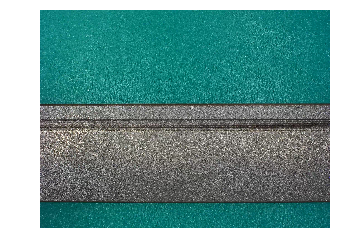